In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import pymcr
from pymcr.mcr import McrAR
from pymcr.regressors import OLS, NNLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
from scipy.integrate import odeint, solve_ivp
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

from pyDOE import lhs
import numpy as np

# Inital Monod Kinetics Model

In [2]:
def ode_system(t,y):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    mu_g_max = (0.74)* 10**-0.75
    Kg = (0.2)* 10**2
    
    mu_c_death = (0.06)* 10**0.25
    Kc = (1)* 10**1.5
    
    k_d = (0.001)* 10**1
    
    Y_xg = (0.052)* 10**0
    
    m_k = (0.06)* 10**-2
    k_c_maint = (0.03)* 10**0    
    
    Y_mx = (20)* 10**-1
    beta = (5)* 10**-0.75
    
    kc = 10**1.5
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    mu_g = 2*(mu_g_max*Cg)/(Kg + Cg)
    
    mu_c = k_d + 2*((mu_c_death*Cc)/(Kc + Cc))
    
    mu_growth = mu_g
    
    mu_death = mu_c
    
    maint_gc = (m_k*Cc)/(k_c_maint + Cc)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
    dXvdt = (mu_growth - mu_death)*Xv 
    
    dXddt = mu_death*Xv
    
    dCgdt = -1*(mu_growth/Y_xg)*Xv - maint_gc*Xv
    
    dCmdt = Y_mx*(mu_growth + beta)*Xv*(Cc/(Cc + kc))
    
    dCcdt = -1*dCmdt
    
    return [dXvdt, dXddt, dCgdt, dCmdt, dCcdt]

In [3]:
def calc_mu_growth(y):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    mu_g_max = (0.74)* 10**-0.75
    Kg = (0.2)* 10**2
        
    mu_g = (mu_g_max*Cg)/(Kg + Cg)
    
    mu_tot = 2*(mu_g)#*(Xv/(Xv+Xd))
    
    return mu_tot

def calc_mu_death(y):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    mu_c_death = (0.06)* 10**0.25
    Kc = (1)* 10**1.5
    
    k_d = (0.001)* 10**1

    mu_c = k_d + 2*((mu_c_death*Cc)/(Kc + Cc))
        
    mu_death = mu_c
    
    return mu_death

def calc_cat_maint(y):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    m_k = (0.06)* 10**-2
    k_c_maint = (0.03)* 10**0
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    maint_gc = (m_k*Cc)/(k_c_maint + Cc)
    
    return maint_gc

In [4]:
y0 = np.array([0.1, 0.0, 82, 0, 20])
tspan = (0, 50)

sol = solve_ivp(ode_system, tspan, y0, method = "Radau")

y_true = np.copy(sol.y)

y_act = sol.y
y_act[0,:] = y_act[0,:] + y_act[1,:]
y_act1 = np.delete(y_act, 1, axis = 0)

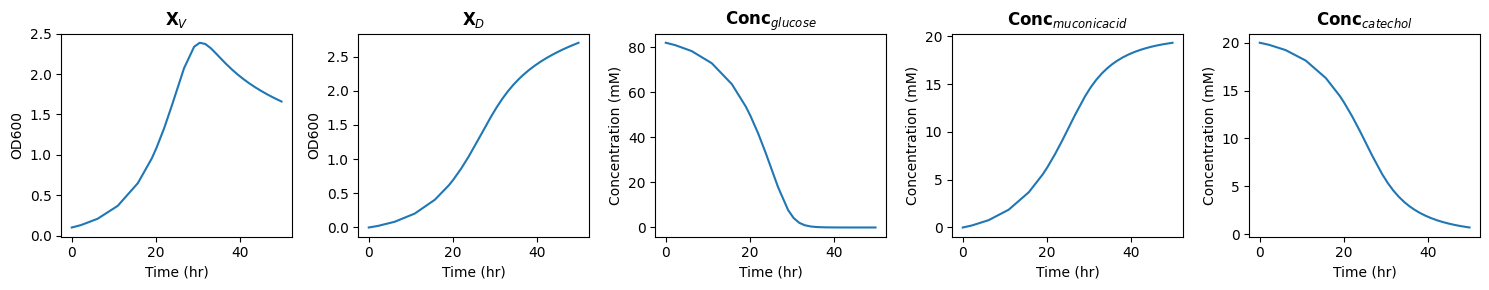

In [5]:
fig, axs = plt.subplots(1,5, figsize = (15,3))
ax = axs.ravel()

Name = ["X$_V$","X$_D$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_true)):
    ax[i].plot(sol.t, y_true[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

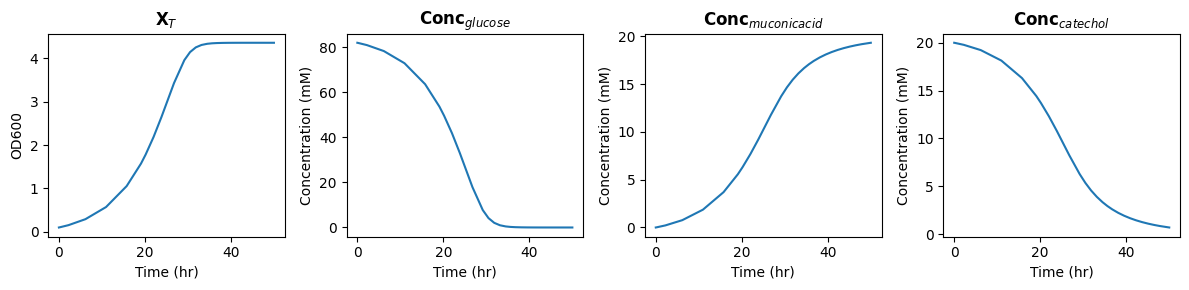

In [6]:
fig, axs = plt.subplots(1, 4, figsize = (12, 3))
ax = axs.ravel()
Name = ["X$_T$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_act1)):
    ax[i].plot(sol.t, y_act1[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

In [7]:
Init_cond = np.loadtxt("Inital_conditions_PP.txt")

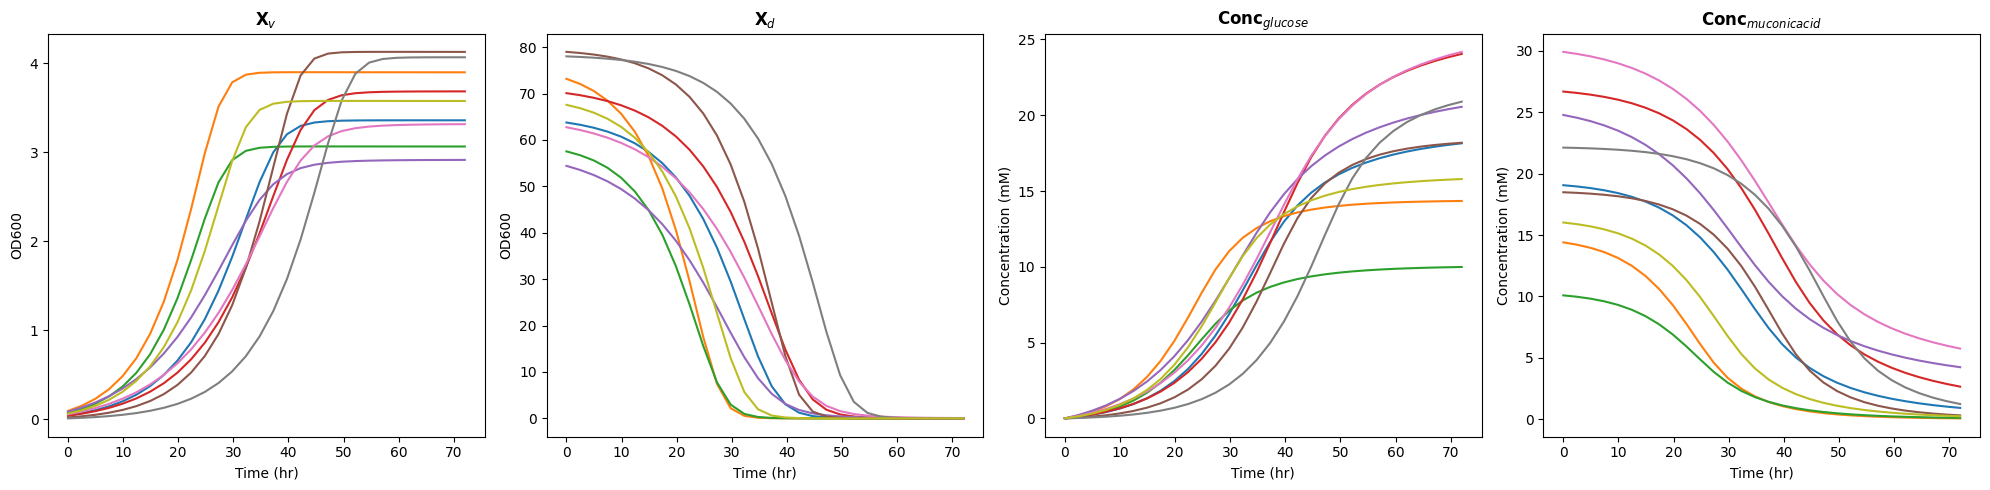

In [8]:
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
axs = axs.ravel()

sol_list = []

for i in range(9):
    
    y0 = Init_cond[i,:]
    tspan = (0, 72)
    teval = np.linspace(tspan[0], tspan[1], 30)
    sol = solve_ivp(ode_system, tspan, y0, method = "Radau", t_eval = teval)
    sol_list.append(sol)
    
    y_act = sol.y
    y_act[0,:] = y_act[0,:] + y_act[1,:]
    y_act = np.delete(y_act, 1, axis = 0)
    
    Name = ["X$_v$", "X$_d$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
    ylabels = ["OD600", "OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

    for j in range(len(y_act)):
        axs[j].plot(sol.t, y_act[j])
        axs[j].set_xlabel("Time (hr)")
        axs[j].set_ylabel(ylabels[j])
        axs[j].set_title(Name[j], fontweight = "bold")
        
plt.tight_layout()

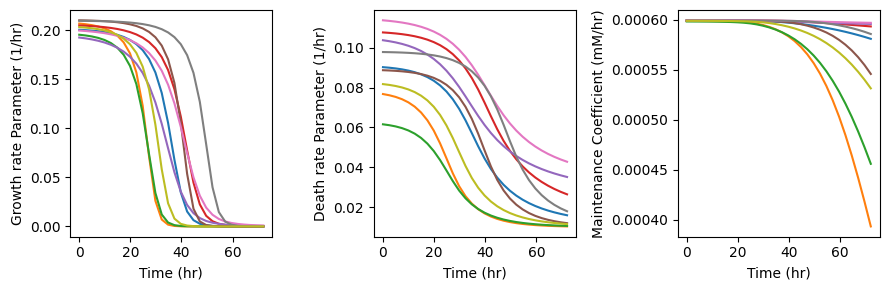

In [9]:
fig, axs = plt.subplots(1,3,figsize = (9, 3))
ax = axs.ravel()

for i in range(len(sol_list)):
    s = sol_list[i]
    ax[0].plot(s.t, calc_mu_growth(s.y))
    ax[1].plot(s.t, calc_mu_death(s.y))
    ax[2].plot(s.t, calc_cat_maint(s.y))
        
    ax[0].set_xlabel("Time (hr)")
    ax[1].set_xlabel("Time (hr)")
    ax[2].set_xlabel("Time (hr)")
    
    ax[0].set_ylabel("Growth rate Parameter (1/hr)")
    ax[1].set_ylabel("Death rate Parameter (1/hr)")
    ax[2].set_ylabel("Maintenance Coefficient (mM/hr)")
    
plt.tight_layout()

# Final Model : monod-logistic bacteria growth model

In [10]:
def combined_ode_system(t,y,y0_g):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    mu_g_max = ((0.74)* 10**-0.75)
    Kg = (0.2)* 10**2
    
    mu_c_death = (0.06)* 10**0.25
    Kc = (1)* 10**1.5
    
    k_d = (0.001)* 10**1
    
    Y_xg = (0.052)* 10**0
    
    m_k = (0.06)* 10**-2
    k_c_maint = (0.03)* 10**0    
    
    Y_mx = (20)* 10**-1
    beta = (5)* 10**-0.75
    
    kc = 10**1.5
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    mu_g = 2*((mu_g_max*Cg)/(Kg + Cg))
    
    Xm = Y_xg*y0_g
    
    log_x = (1-(Xv/Xm))
    
    mu_growth = mu_g*log_x
    
    mu_death = k_d + ((mu_c_death*Cc)/(Kc + Cc))/2
    
    maint_gc = (m_k*Cc)/(k_c_maint + Cc)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
    dXvdt = (mu_growth - mu_death)*Xv 
    
    dXddt = mu_death*Xv
    
    dCgdt = -1*(mu_growth/Y_xg)*Xv - maint_gc*Xv
    
    dCmdt = Y_mx*(mu_growth + beta)*Xv*(Cc/(Cc + kc))
    
    dCcdt = -1*dCmdt
    
    return [dXvdt, dXddt, dCgdt, dCmdt, dCcdt]

In [11]:
def calc_mu_growth(y, y0_g):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    mu_g_max = ((0.74)* 10**-0.75)
    Kg = (0.2)* 10**2
    
    Y_xg = (0.052)* 10**0
        
    mu_g = 2*(mu_g_max*Cg)/(Kg + Cg)
    
    Xm = Y_xg*y0_g
    
    log_x = (1-(Xv/Xm))
    
    mu_growth = mu_g*log_x
    
    return mu_growth

def calc_mu_death(y):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    mu_c_death = (0.06)* 10**0.25
    Kc = (1)* 10**1.5
    
    k_d = (0.001)* 10**1

    mu_c = k_d + ((mu_c_death*Cc)/(Kc + Cc))/2
        
    mu_death = mu_c
    
    return mu_death

def calc_cat_maint(y):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    m_k = (0.06)* 10**-2
    k_c_maint = (0.03)* 10**0
    
    maint_gc = (m_k*Cc)/(k_c_maint + Cc)
    
    return maint_gc

def calc_fv(y):

    Xv, Xd, Cg, Cm, Cc = y

    fv = (Xv)/(Xv + Xd)

    return fv

In [20]:
y0 = np.array([0.1, 0.0, 42, 0, 20])
tspan = (0, 72)

sol = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), method = "Radau")

y_true = np.copy(sol.y)

y_act = sol.y
y_act[0,:] = y_act[0,:] + y_act[1,:]
y_act1 = np.delete(y_act, 1, axis = 0)

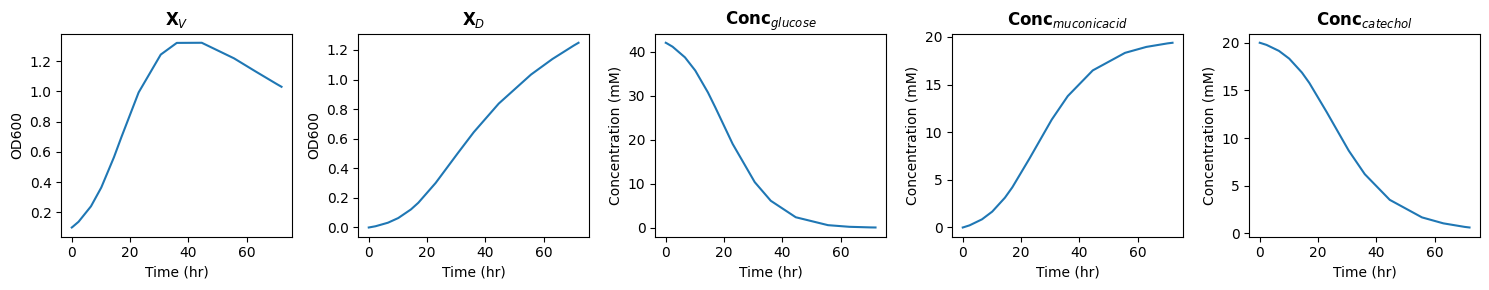

In [21]:
fig, axs = plt.subplots(1,5, figsize = (15,3))
ax = axs.ravel()

Name = ["X$_V$","X$_D$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_true)):
    ax[i].plot(sol.t, y_true[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

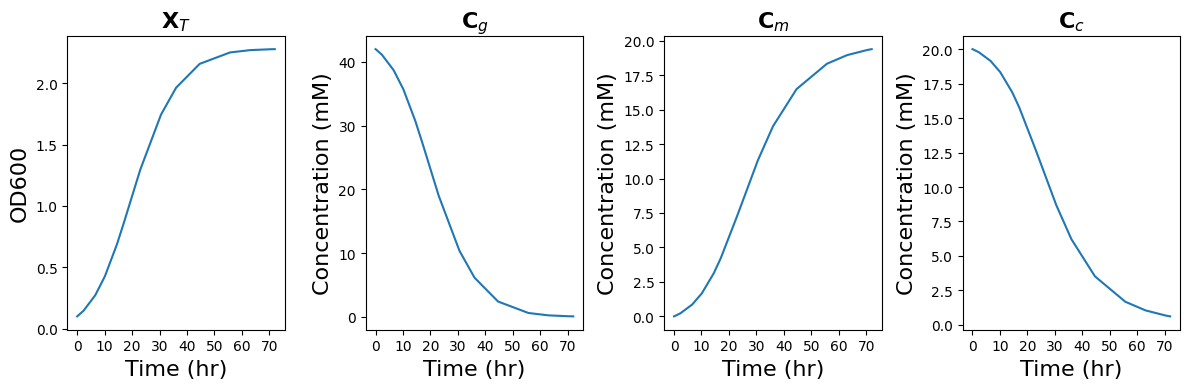

In [22]:
fig, axs = plt.subplots(1, 4, figsize = (12, 4), sharex = True)
ax = axs.ravel()
Name = ["X$_T$", "C$_{g}$", "C$_{m}$", "C$_{c}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_act1)):
    ax[i].plot(sol.t, y_act1[i,:])
    ax[i].set_xlabel("Time (hr)", fontsize = 16)
    ax[i].set_xticks([0,10,20,30,40,50,60,70], labels = [0,10,20,30,40,50,60,70])
    ax[i].set_ylabel(ylabels[i], fontsize = 16)
    ax[i].set_title(Name[i], fontweight = "bold", fontsize = 16)

plt.tight_layout()
plt.savefig("ground_truth.svg")

In [22]:
Init_cond = np.loadtxt("Inital_conditions_PP.txt")

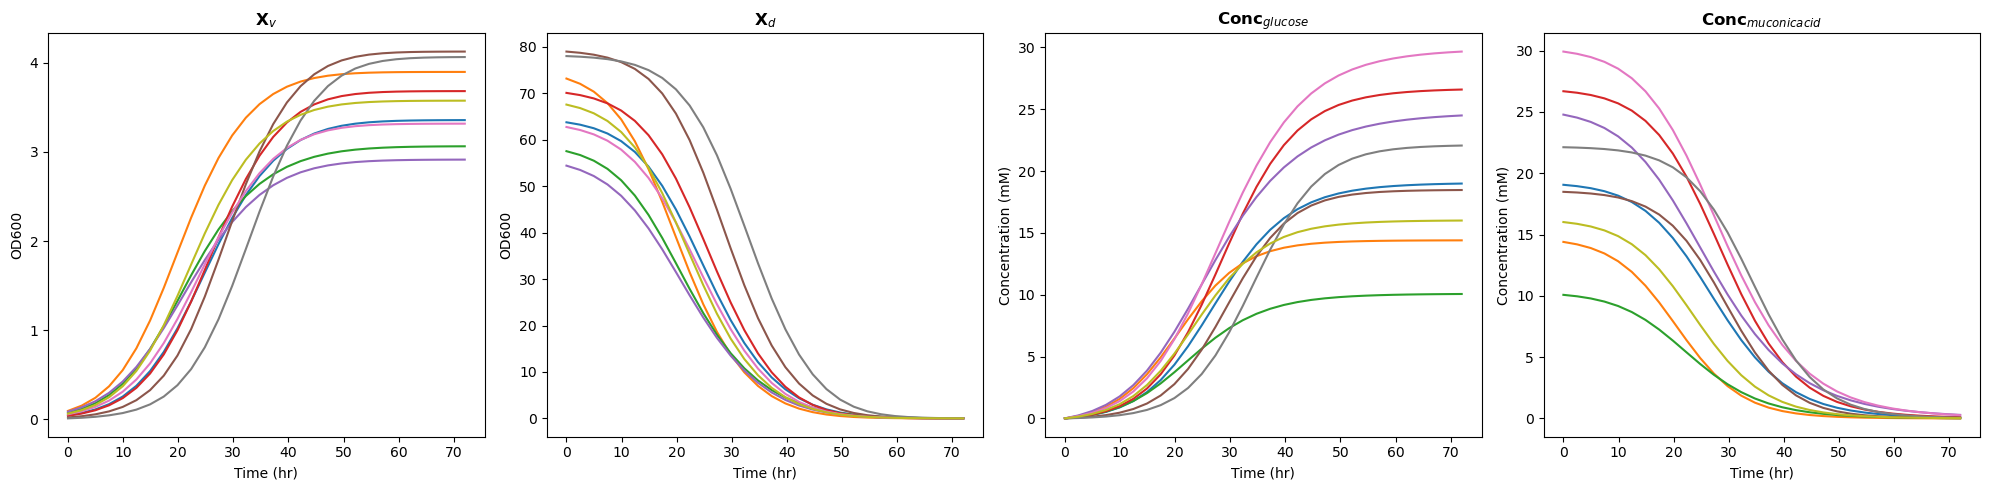

In [23]:
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
axs = axs.ravel()

sol_list = []

for i in range(9):
    
    y0 = Init_cond[i,:]
    tspan = (0, 72)
    teval = np.linspace(tspan[0], tspan[1], 30)
    sol = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), method = "Radau", t_eval = teval)
    sol_list.append(sol)
    
    y_act = sol.y
    y_act[0,:] = y_act[0,:] + y_act[1,:]
    y_act = np.delete(y_act, 1, axis = 0)
    
    Name = ["X$_v$", "X$_d$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
    ylabels = ["OD600", "OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

    for j in range(len(y_act)):
        axs[j].plot(sol.t, y_act[j])
        axs[j].set_xlabel("Time (hr)")
        axs[j].set_ylabel(ylabels[j])
        axs[j].set_title(Name[j], fontweight = "bold")
        
plt.tight_layout()

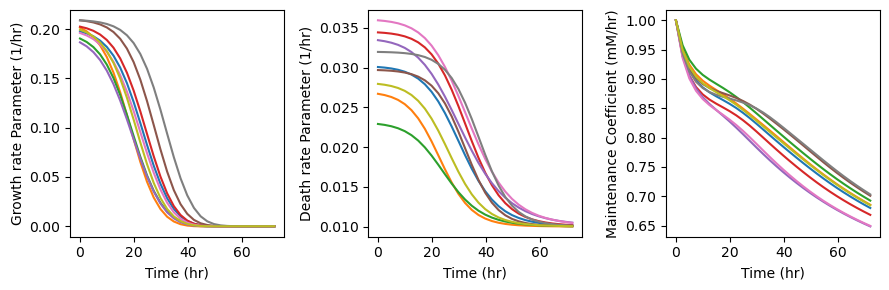

In [24]:
fig, axs = plt.subplots(1,3,figsize = (9, 3))
ax = axs.ravel()

for i in range(len(sol_list)):
    s = sol_list[i]
    ax[0].plot(s.t, calc_mu_growth(s.y, Init_cond[i,:][2]))
    ax[1].plot(s.t, calc_mu_death(s.y))
    ax[2].plot(s.t, calc_fv(s.y))
        
    ax[0].set_xlabel("Time (hr)")
    ax[1].set_xlabel("Time (hr)")
    ax[2].set_xlabel("Time (hr)")
    
    ax[0].set_ylabel("Growth rate Parameter (1/hr)")
    ax[1].set_ylabel("Death rate Parameter (1/hr)")
    ax[2].set_ylabel("Maintenance Coefficient (mM/hr)")
    
plt.tight_layout()

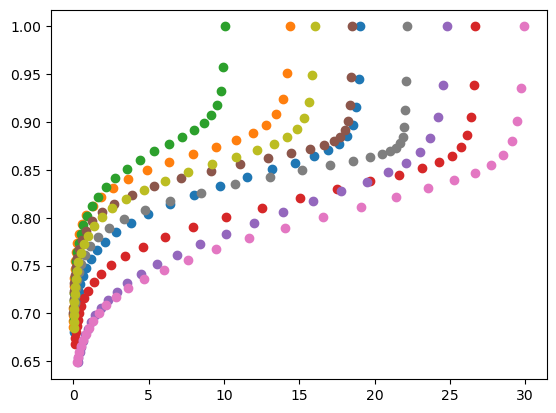

In [28]:
for i in range(len(sol_list)):
    s = sol_list[i]

    plt.scatter(s.y[-1], calc_fv(s.y))

In [18]:
# for i in range(len(Init_cond[0,:])):
#     print("Range: ")
#     print(np.min(Init_cond[:,i]), np.max(Init_cond[:,i]))
#     print("~~~~~~~~~~~~~~~~~")

In [19]:
Xv_range = [0.01, 0.01]
Xd_range = [0,0]
Cg_range = [50, 70]
Cm_range = [0,0]
Cc_range = [25, 35]

In [20]:
n_samples = 3
n_dimensions = 5

# Generate the LHS
lhs_sample = lhs(n_dimensions, samples=n_samples)

In [21]:
Init_cond7 = np.zeros(lhs_sample.shape)

Init_cond7[:,0] = lhs_sample[:,0]*(Xv_range[1]-Xv_range[0]) + Xv_range[0]
Init_cond7[:,1] = lhs_sample[:,1]*(Xd_range[1]-Xd_range[0]) + Xd_range[0]
Init_cond7[:,2] = lhs_sample[:,2]*(Cg_range[1]-Cg_range[0]) + Cg_range[0]
Init_cond7[:,3] = lhs_sample[:,3]*(Cm_range[1]-Cm_range[0]) + Cm_range[0]
Init_cond7[:,4] = lhs_sample[:,4]*(Cc_range[1]-Cc_range[0]) + Cc_range[0]

In [22]:
for i in range(len(Init_cond7[0,:])):
    print("Range: ")
    print(np.min(Init_cond7[:,i]), np.max(Init_cond7[:,i]))
    print("~~~~~~~~~~~~~~~~~")

Range: 
0.01 0.01
~~~~~~~~~~~~~~~~~
Range: 
0.0 0.0
~~~~~~~~~~~~~~~~~
Range: 
50.768345933732824 68.98652557827103
~~~~~~~~~~~~~~~~~
Range: 
0.0 0.0
~~~~~~~~~~~~~~~~~
Range: 
27.44879269668375 33.59115319111262
~~~~~~~~~~~~~~~~~


In [23]:
np.savetxt("Initial_conditions_3_2_PP.txt", Init_cond7)